# Ride-sharing: understanding passenger preferences and the impact of external factors on rides.

The main goal of this analysis is to provide Zuber, a new ride-sharing company that's launching in Chicago, with relevant insight on passenger preferences and the impact of external factors on rides.


We have previously parsed web weather data from the website: https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html and combined it within a SQL database containing data on taxi rides in Chicago as showed in this scheme:

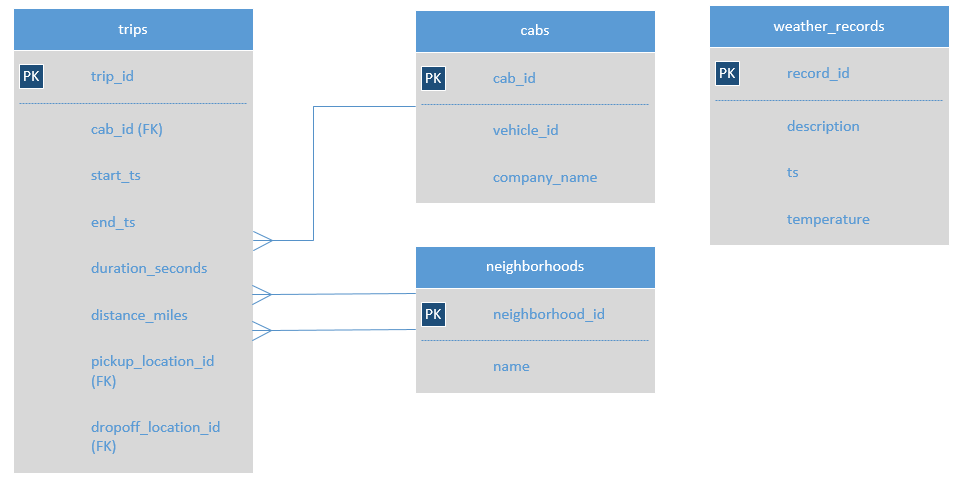


After performing an introductory analysis using SQL, we have come up with the following conclusions:

    - 1. The companies with the largest count of trips started in November 15-16, 2017 were Flash Cab (19558 rides) and Taxi Affiliation Services (11422 rides). The one starting the fewest trips was 3556 - 36214 RC Andrews Cab, getting only 2 trips.
    
    - 2. For the week comprised between November 1-7, 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services, as well:
    
        company_name	     trips_amount
            Other	            335771
            Flash Cab	         64084
     Taxi Affiliation Services    37583

    - 3. The average duration of trips that started in the Loop on a Saturday and ended at O'Hare in days with bad weather conditions (storm/rain) seems to be higher than that of days with good weather conditions: 

        weather_conditions	avg_seconds
            Bad	             2427.21
            Good	            1999.68

        
In addition to the data retrieved above, we'll study data from two CSV files containing the following information:

- ``project_sql_result_01.csv.``:
    - company_name: taxi company name
    - trips_amount: the number of rides for each taxi company on November 15-16, 2017.
    
    
- ``project_sql_result_04.csv.``:
- dropoff_location_name: Chicago neighborhoods where rides ended
- average_trips: the average number of rides that ended in each neighborhood in November 2017.



Next, we will:

1) Import the files

2) Study the data they contain

3) Make sure the data types are correct

4) Identify the top 10 neighborhoods in terms of drop-offs

5) Make graphs: taxi companies and number of rides, top 10 neighborhoods by number of dropoffs

6) Draw conclusions based on each graph and explain the results


7) Finally, we'll parse data from a third CSV file compiling data on rides from the Loop to O'Hare International Airport to the aim of testing the following hypothesis: 

"The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

These are the table's field values:

- ``project_sql_result_07.csv.``:

- start_ts — pickup date and time
- weather_conditions — weather conditions at the moment the ride started
- duration_seconds — ride duration in seconds



## 1) Import the files

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import stats as st
from scipy import stats
import seaborn as sns


In [2]:
# Load companies data into a Dataframe
try:
    comp_df=pd.read_csv('C:/Users/josef/Practicum/Project 5/project_sql_result_01.csv')
except:
    comp_df=pd.read_csv('/datasets/project_sql_result_01.csv')

In [3]:
# Load destinations data into a Dataframe
try:
    dest_df=pd.read_csv('C:/Users/josef/Practicum/Project 5/project_sql_result_04.csv')
except:
    dest_df=pd.read_csv('/datasets/project_sql_result_04.csv')

In [4]:
# Load trips data into a Dataframe
try:
    trips_df=pd.read_csv('C:/Users/josef/Practicum/Project 5/project_sql_result_07.csv')
except:
    trips_df=pd.read_csv('/datasets/project_sql_result_07.csv')

## 2) Study the data they contain

In [5]:
#Print trips data overview
comp_df.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [6]:
#Print trips_amount per company summary statistics
comp_df.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


In [7]:
#Print drop-offs data overview
dest_df.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [8]:
#Print average trips summary statistics
dest_df.describe()

,average_trips
count,94.000000
mean,599.953728
std,1714.591098
min,1.800000
25%,14.266667
50%,52.016667
75%,298.858333
max,10727.466667


In [9]:
#Print trips data overview
trips_df.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [10]:
#Print duration_seconds summary statistics
trips_df.describe()

,duration_seconds
count,1068.000000
mean,2071.731273
std,769.461125
min,0.000000
25%,1438.250000
50%,1980.000000
75%,2580.000000
max,7440.000000


## 3) a) Check for duplicated rows

In [11]:
#Check for duplicates in companies dataset
comp_df.duplicated().sum()

0

In [12]:
#Check for duplicates in destination dataset
dest_df.duplicated().sum()

0

In [13]:
#Check for duplicates in destination dataset
trips_df.duplicated().sum()

197

In [14]:
#Calculate % of duplicated rows
trips_df.duplicated().sum()/len(trips_df)

0.18445692883895132

In [15]:
#Overview of duplicated rows
trips_df[trips_df.duplicated()]

,start_ts,weather_conditions,duration_seconds
62,2017-11-11 06:00:00,Good,1260.0
74,2017-11-11 08:00:00,Good,1380.0
76,2017-11-04 09:00:00,Good,1380.0
117,2017-11-11 07:00:00,Good,1380.0
119,2017-11-04 14:00:00,Good,3300.0
...,...,...,...
1054,2017-11-11 07:00:00,Good,1380.0
1058,2017-11-25 12:00:00,Good,1440.0
1062,2017-11-11 06:00:00,Good,1500.0
1065,2017-11-11 13:00:00,Good,2100.0


Since there are only three columns and start times were gathered with hour precision only (no minutes and seconds are disclosed), we won't drop duplicates because they might correspond to different trips that had the same duration and started within the same hour. 

## 3) b) Check data types are correct

In [16]:
#Print trips data info
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [17]:
#Print drop-offs data info
dest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [18]:
#Print trips data info
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


After getting a high level data overview, the general conclusions are as follows:

- Columns are correctly named, following the snake_case format in lower-case characters.

- There are no missing values (64, 94 and 1068 non-null values matching the lenght of each dataset).

- ``trips_amount`` (companies data) and ``duration_seconds`` (trips data) were correctly imported as integer and float type. 

However, we'll need to fix these data types before moving forward with the analysis:

- ``average_trips`` (destinations data) will be converted to integer (as there can't possibly be fractions of trips to a given destination).

- ``start-ts`` (trips data) will be parsed as a datetime column instead of a string-type one. 


## 3) c) Fix data types

In [19]:
# Change average_trips to integer

dest_df['average_trips'] = dest_df['average_trips'].astype(int)

In [20]:
# Verify change
dest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dropoff_location_name  94 non-null     object
 1   average_trips          94 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [21]:
# Change start_ts to datetime
trips_df['start_ts'] = pd.to_datetime(trips_df['start_ts'])

In [22]:
# Verify change
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


## 4) Identify the top 10 neighborhoods in terms of drop-offs

In [23]:
#Verify that there are no duplicated names
dest_df.dropoff_location_name.duplicated().sum()

0

In [24]:
#Print ten top destinations based on average trips
dest_df.sort_values(by='average_trips', ascending=False).head(10)

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546
5,Lake View,2420
6,Grant Park,2068
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1259


## 5) a) Plot distribution of the top 10 neighborhoods by number of dropoffs


Next, we'll plot the results printed above to get a more visual insight on the average count of trips ended in each location daily.

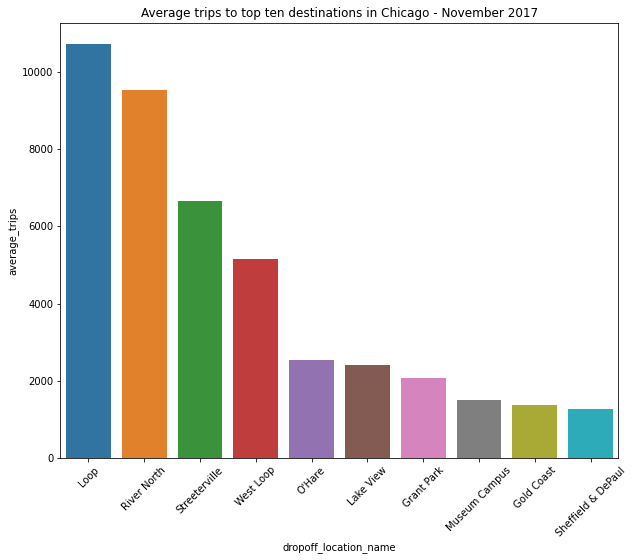

In [25]:
#Plot average trips by drop-off location
plt.figure(figsize=(10,8))
ax = sns.barplot(x="dropoff_location_name", y="average_trips", data=dest_df.sort_values(by='average_trips', ascending=False).head(10))

#add overall title to plot
ax.set(title='Average trips to top ten destinations in Chicago - November 2017')
plt.xticks(rotation=45)
plt.show()

We'll add a boxplot with the dispersion of average dropoffs at each location




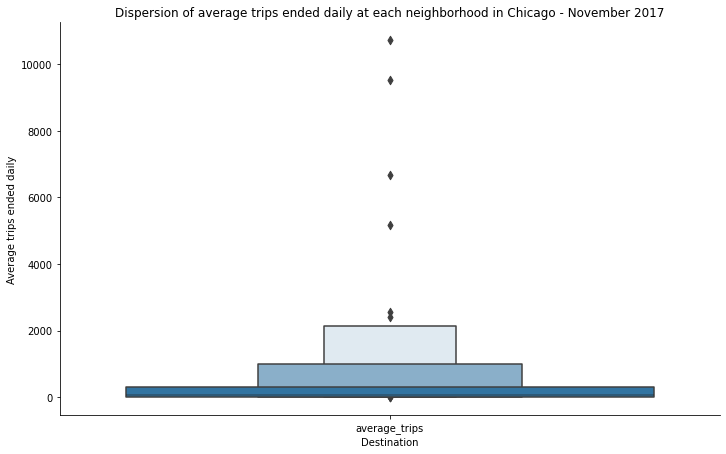

In [26]:
#Plot dispersion of average trips per destination
sns.catplot( kind="boxen", data=dest_df.sort_values(by='average_trips', ascending=False), height=6, aspect=10/6)

plt.title('Dispersion of average trips ended daily at each neighborhood in Chicago - November 2017')

plt.xlabel('Destination')
plt.ylabel('Average trips ended daily');

plt.show()

## 6) a) Conclusions: dropoff locations

Based on the analysis of the top ten destination neighborhoods we can see that the one where the highest average of trips ended daily (Loop = 10.7 k trips) received more than 8 times as many passengers as the tenth most frequently chosen location (Sheffield & DePaul = 1.3 k trips). 

It's clear that there were only a few destinations where a very high average of daily trips ended in November, but a high concentration of locations receiving a small average of rides each day.

The top eight destinations, excluding O'hare, are 10 minutes away from one another. Hence, the company should focus in keeping the majority of drivers within that zone.

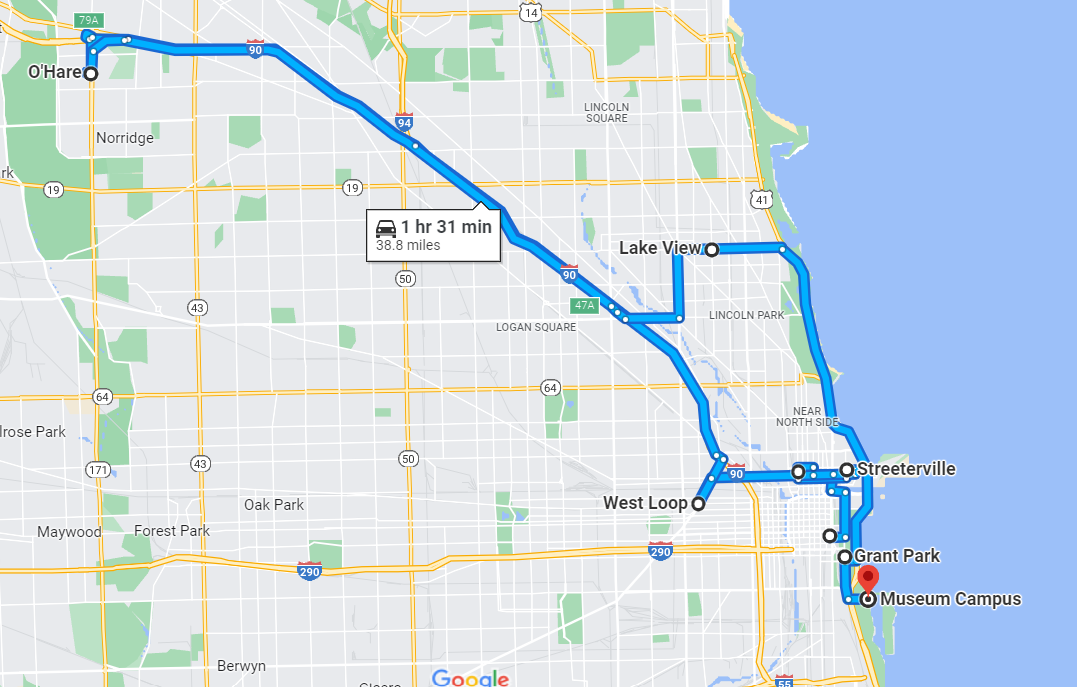


## 5) b) Plot taxi companies and number of rides


Now we'll do the same with taxi companies and trips amount on November 15-16, 2017.

In [27]:
#Top five companies in terms of trips performed
comp_df.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


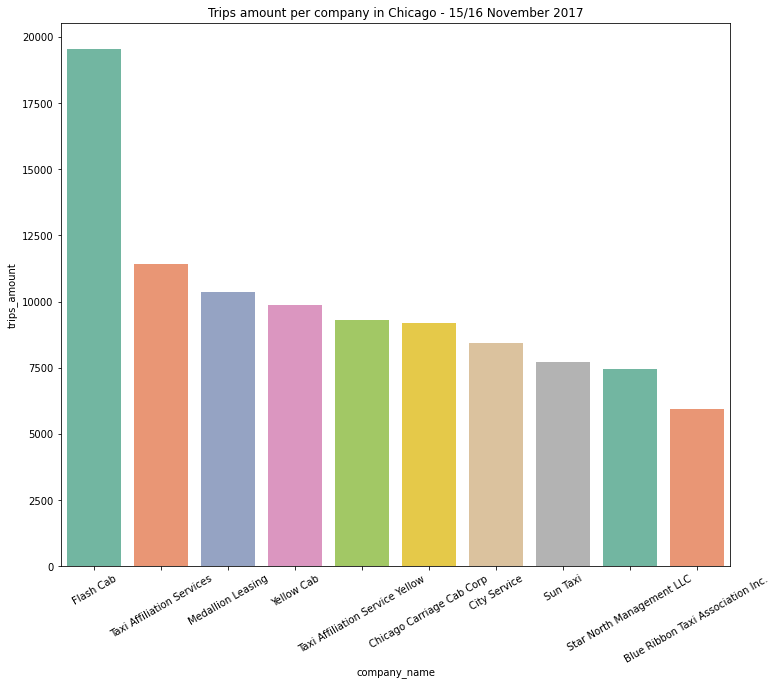

In [28]:
#Plot total trips per company on November 15-16, 2017 
plt.figure(figsize=(12,10))
ax = sns.barplot(x="company_name", y="trips_amount", data=comp_df.sort_values(by='trips_amount', ascending=False).head(10), palette="Set2")

#add overall title to plot
ax.set(title='Trips amount per company in Chicago - 15/16 November 2017')
plt.xticks(rotation=30)
plt.show()


## 6) b) Conclusions: taxi companies

The strongest competitor in Chicago ride sharing market is Flash Cab, achieving 19.6 k trips on 15-16 November, 2017.

Taxi Affiliation Services follows, with 11.4 k trips started on the same date. This company has a second line called "yellow", which is the fifth most important in the plot above.

Zuber should direct its efforts to understand their value proposition, and identify aspects where they could offer advantages to customers (eg. quicker response time, cheaper trips, etc.), in order to capture a considerable market share. 


## 7) Hypothesis testing: "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

The trips_df dataframe contains data on rides from the Loop to O'Hare International Airport on Saturdays. Remember, these are the table's field values:

- start_ts — pickup date and time
- weather_conditions — weather conditions at the moment the ride started
- duration_seconds — ride duration in seconds

In [29]:
#Make sure it only contains data from Saturdays
trips_df['day_of_week']= trips_df['start_ts'].apply(lambda x: x.weekday())
trips_df['day_of_week'].value_counts()

5    1068
Name: day_of_week, dtype: int64

In [30]:
#print first and last day when trips were performed

min_date= trips_df['start_ts'].min()
max_date= trips_df['start_ts'].max()
dif_days= (max_date-min_date).days

print(f'The first trip started on {min_date} and the last one on {max_date}. Information from {dif_days} days was captured.')

The first trip started on 2017-11-04 00:00:00 and the last one on 2017-11-25 23:00:00. Information from 21 days was captured.


In [31]:
#print mean and median duration of trips for each weather condition
trips_df.groupby('weather_conditions')['duration_seconds'].agg(['mean','median','count'])

,mean,median,count
weather_conditions,,,
Bad,2427.205556,2540.0,180
Good,1999.675676,1800.0,888


The count of rides with bad weather is almost eight times smaller than the ones performed under good weather conditions. This can be either because the weather is not frequently rainy or stormy in Chicago, or because people tend to stay at home and travel less when it's rainy.

We'll compare the average trips per hour for both weather conditions to assess which theory is correct

In [32]:
# Compare the sum of rides under each weather condition with the count of hours when the weather was good and bad. Get the mean as well
hourly_trips=trips_df.pivot_table(index=['start_ts', 'weather_conditions'], values='duration_seconds', aggfunc='count')

hourly_trips.groupby('weather_conditions')['duration_seconds'].agg(['count','sum', 'mean','median'])

,count,sum,mean,median
weather_conditions,,,,
Bad,13,180,13.846154,14.0
Good,68,888,13.058824,7.5


In [33]:
#reset index to make plotting easier
hourly_trips.reset_index(inplace=True)
hourly_trips

,start_ts,weather_conditions,duration_seconds
0,2017-11-04 00:00:00,Good,1
1,2017-11-04 01:00:00,Good,1
2,2017-11-04 02:00:00,Good,1
3,2017-11-04 04:00:00,Good,5
4,2017-11-04 05:00:00,Good,9
...,...,...,...
76,2017-11-25 17:00:00,Good,5
77,2017-11-25 18:00:00,Good,7
78,2017-11-25 19:00:00,Good,1
79,2017-11-25 20:00:00,Good,2


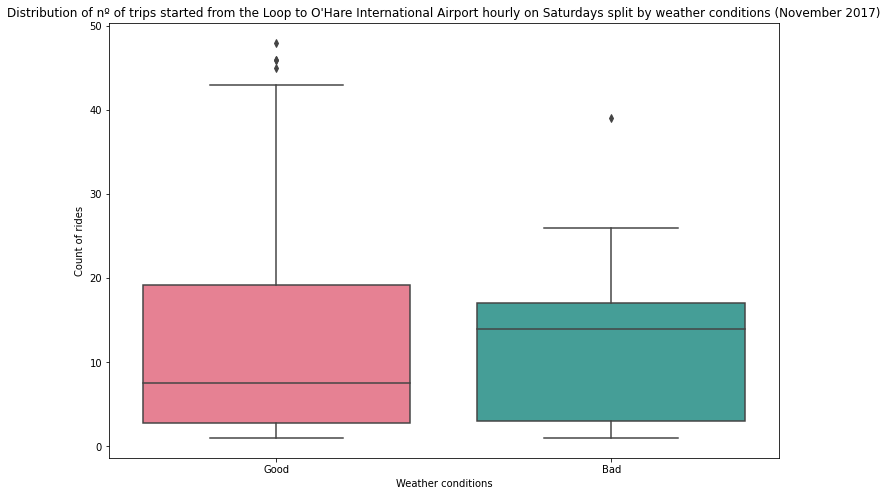

In [34]:
#PLot distribution of average annual sales per game for each platform (active, from 2013 to 2016)
plt.figure(figsize=(12,8))
sns.boxplot(data=hourly_trips, x= 'weather_conditions', y= 'duration_seconds', palette= "husl")

plt.title('Distribution of nº of trips started from the Loop to O\'Hare International Airport hourly on Saturdays split by weather conditions (November 2017)')
plt.xlabel('Weather conditions')
plt.ylabel('Count of rides');

The average count of trips started hourly is stable regardless of weather conditons. However, the median count of rides was almost twice as high when the weather was good, since a spike in the count of rides in some hours with good weather is skewing the mean right. This might be due to more people getting to the Airport at a rush-hour, or at night, and not related to the weather conditions themselves. The conclusion we can get to, is that weather conditions are not hitting the amount of rides started, but they are impacting on their duration. 

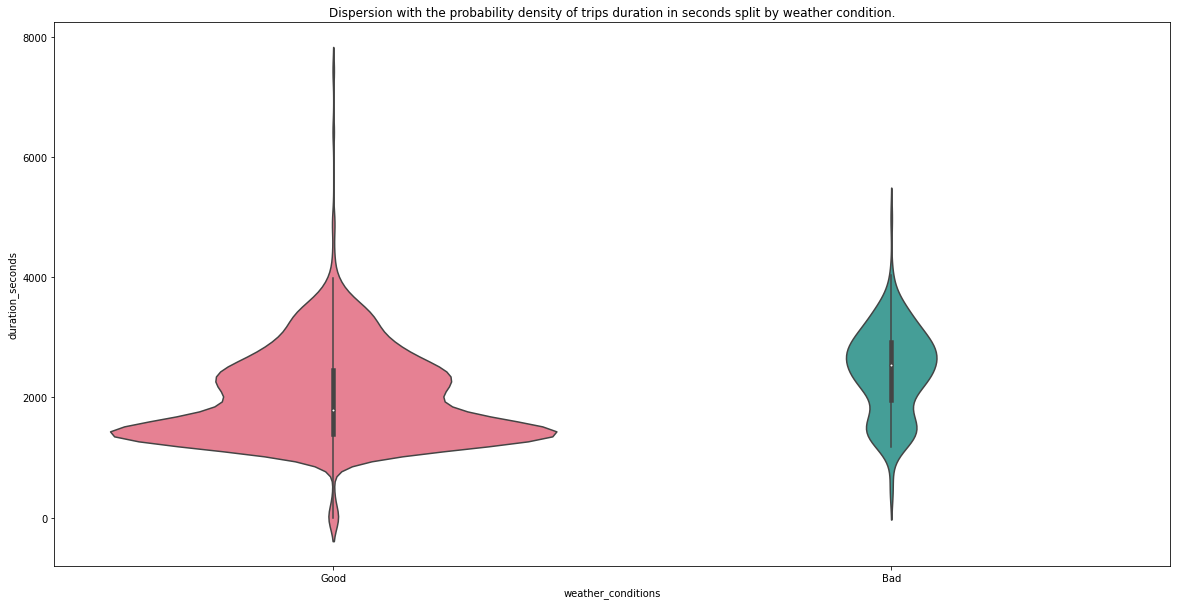

In [35]:
#plot dispersion of trips duration in seconds with kde
sns.violinplot(x="weather_conditions", y="duration_seconds",
                    data=trips_df,
                    scale="count", kind='boxen', palette= "husl")
plt.gcf().set_size_inches(20, 10)
plt.title('Dispersion with the probability density of trips duration in seconds split by weather condition.')

plt.show()

The violin drafting the dispersion of rides duration in hours with good weather is wider when the duration is shorter, and the other one is wider at the top, and narrower at the bottom. This means that in most hours the weather was good and the trips duration remained shorter than 2000 seconds. However, when the weather was bad, most trips lasted between 2000 and 3000 seconds. 

Since we're working with a sample including only data from Saturdays of November 2017, we'll use hypothesis testing to assess whether the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.


Null hypothesis: "The average duration of rides from the Loop to O'Hare International Airport is the same on rainy Saturdays"

Alternative hypothesis: "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays"

Statistical test: Hypothesis on the Equality of Two Population Mean.

alpha= 0.05

In [36]:
#Define parameters to test the hypothesis
rainy_saturdays = trips_df.query('weather_conditions =="Bad"')['duration_seconds']
not_rainy_saturdays = trips_df.query('weather_conditions =="Good"')['duration_seconds']
alpha=0.05

In [37]:
#Apply levene test to decide on whether there are reasons to set equal_var as false

p_value_levene=stats.levene(rainy_saturdays,not_rainy_saturdays).pvalue
if p_value_levene<alpha:
    print(p_value_levene, False)
else:
    print(p_value_levene, True)


0.5332038671974493 True


In [38]:
# Test the hypothesis

results=st.ttest_ind(rainy_saturdays,not_rainy_saturdays, equal_var=True)
print(results.pvalue)

if results.pvalue<alpha:
    
    print('We reject the null hypothesis. The average ride duration differs on rainy Saturdays')
    
else:
    
    print('We can\'t reject the null hypothesis')

6.517970327099473e-12
We reject the null hypothesis. The average ride duration differs on rainy Saturdays


/tmp/ipykernel_54/773375490.py:3: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  results=st.ttest_ind(rainy_saturdays,not_rainy_saturdays, equal_var=True)


**Conclusion**: Based on this hypothesis testing, we can ensure that the average trip duration is different in rainy Saturdays. This makes sense from the perspective that traffic is usually more caothic when the weather conditions are averse. Knowing this beforehand will come in very handy when forecasting the demand of cars available on rainy days. Since riders will take longer to end their trip, we will need more of them on the road to cover passsengers needs.

# General Summary

This analysis was aimed to provide Zuber, a new ride-sharing company that's launching in Chicago, with relevant insight on passenger preferences and the impact of external factors on rides.

At an earlier stage, after parsing web weather data from the website: https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html and combining it within a SQL database containing data on taxi rides in Chicago, we came up with the following conclusions:

     - 1. The companies with the largest count of trips started in November 15-16, 2017 were Flash Cab (19558 rides) and Taxi Affiliation Services (11422 rides). The one starting the fewest trips was 3556 - 36214 RC Andrews Cab, getting only 2 trips.
    
    - 2. For the week comprised between November 1-7, 2017, the most popular taxi companies were Flash Cab and Taxi Affiliation Services, as well:
    
        company_name	     trips_amount
            Other	            335771
            Flash Cab	         64084
     Taxi Affiliation Services    37583

    - 3. The average duration of trips that started in the Loop on a Saturday and ended at O'Hare in days with bad weather conditions (storm/rain) seems to be higher than that of days with good weather conditions: 

        weather_conditions	avg_seconds
            Bad	             2427.21
            Good	            1999.68

In addition to the abovementioned, we got data from three CSV files:

- ``project_sql_result_01.csv.``:
    - company_name: taxi company name
    - trips_amount: the number of rides for each taxi company on November 15-16, 2017.
    
    
- ``project_sql_result_04.csv.``:
- dropoff_location_name: Chicago neighborhoods where rides ended
- average_trips: the average number of rides that ended in each neighborhood in November 2017.

- ``project_sql_result_07.csv.``:

- start_ts — pickup date and time
- weather_conditions — weather conditions at the moment the ride started
- duration_seconds — ride duration in seconds

We analyzed them as follows:

1) We imported the files and after printing a general overview of the features within each dataset, we checked for duplicated rows. Even though 197 rows (18% of the dataset) were potentially duplicated, we decided not to get rid of them. The foundation for such decision was that since there are only three columns and start times were gathered with hour precision only (no minutes and seconds are disclosed), duplicated rows might correspond to different trips that had the same duration and started within the same hour.

2) We assessed data types were imported correctly, and ended up modifying two columns dtype:

``average_trips`` (destinations data) was converted from float to integer (as there can't possibly be fractions of trips to a given destination).

``start-ts`` (trips data) was parsed as a datetime column instead of a string-type one.

3) Using the dataset containing average trips ended daily at each location in November 2017, we identified the top 10 neighborhoods in terms of dropoffs by printing the first ten rows of the dataset, sorted by average trips in descending order, and plotted them in a bar chart.
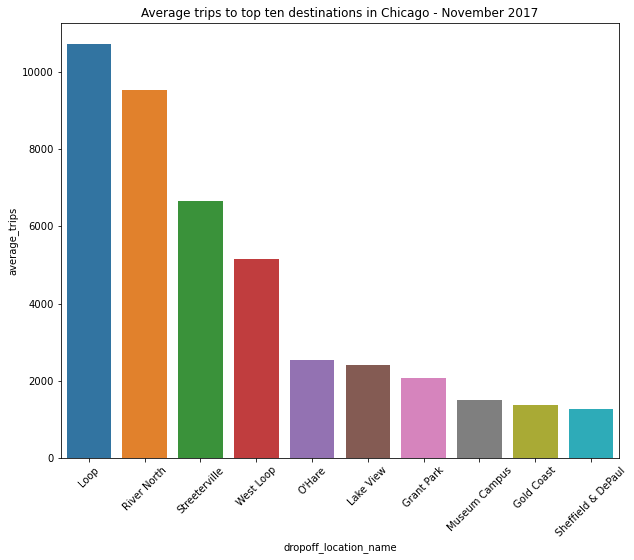

This revealed that the neighborhood where the highest average of trips ended daily (Loop = 10.7 k trips) received more than 8 times as many passengers as the tenth most frequently chosen location (Sheffield & DePaul = 1.3 k trips).

Next, we drew a boxen catplot showing the dispersion of average trips ended daily at each neighborhood, and reached to the conclusion that there were only a few destinations where a very high average of daily trips ended in November, but a high concentration of locations receiving a small average of rides each day.

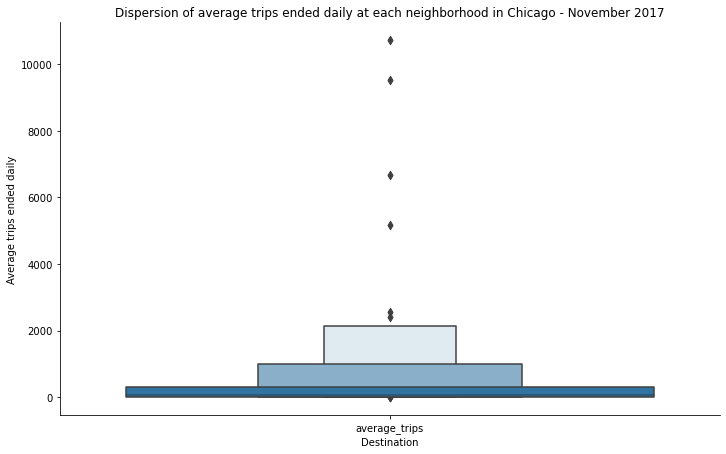

We searched the top 8 locations in Maps, and realized that every dropoff locations except for O'Hare (which corresponds to an airport and is ranked 5th in the top 10 list), are within a 10 minutes driving distance from one another.
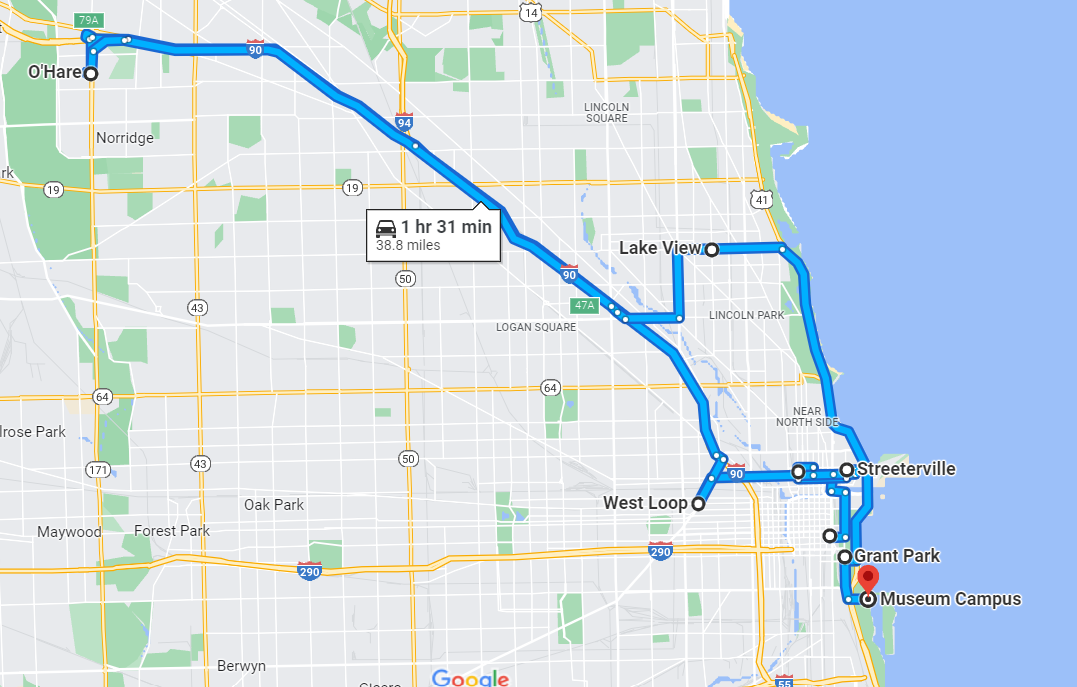

**Therefore, the company should focus in keeping the majority of drivers within that zone.**

4) The following step consisted of plotting the trips amount per taxi company on November 15-16, 2017.

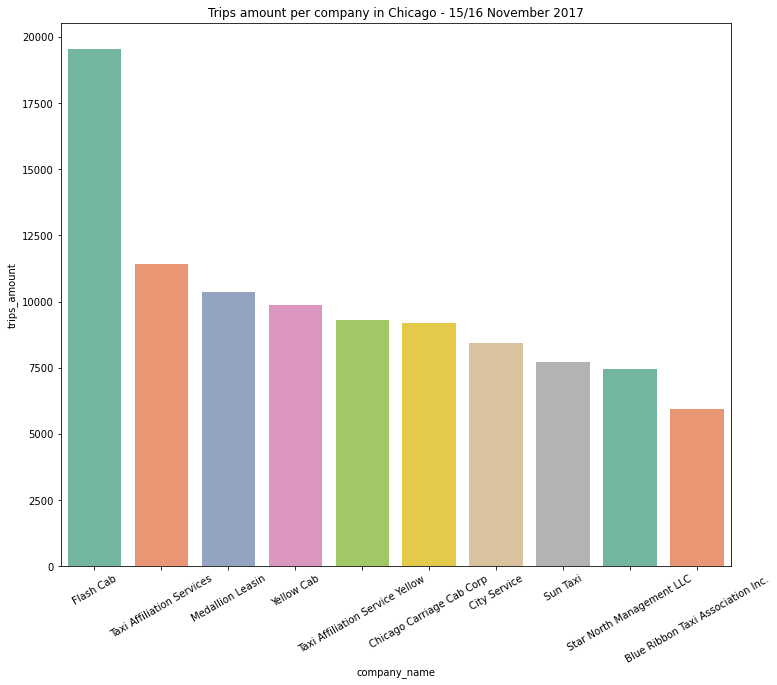

We found out that Flash Cab was the strongest competitor in Chicago ride sharing market, achieving 19.6 k trips on 15-16 November, 2017.

Taxi Affiliation Services followed, with 11.4 k trips started on the same date. This company has a second line called "yellow", which is the fifth most important in the plot above.

**Zuber should direct its efforts to understand their value proposition, and identify aspects where they could offer advantages to customers (eg. quicker response time, cheaper trips, etc.) over the main market players, in order to be able to capture a considerable market share.**

5) Based on the trips dataset, containing start dates with hour precision, duration in seconds and weather condition (good/bad), we focused on evaluating whether duration changed on rainy Saturdays (recall that the dataset contains only data from November 2017).

Firstly, we ensured that every start date corresponded to a Saturday. Then, we printed the mean and median duration for each weather condition value, as well as the count of hours at which the weather was good and bad.

The count of rides with bad weather was almost eight times smaller than the ones performed under good weather conditions. This can be either because the weather was not frequently rainy or stormy in Chicago, or because people tend to stay at home and travel less when it's rainy.

To assess which theory is correct, we compared the average trips per hour for both weather conditions, with the help of a boxplot.
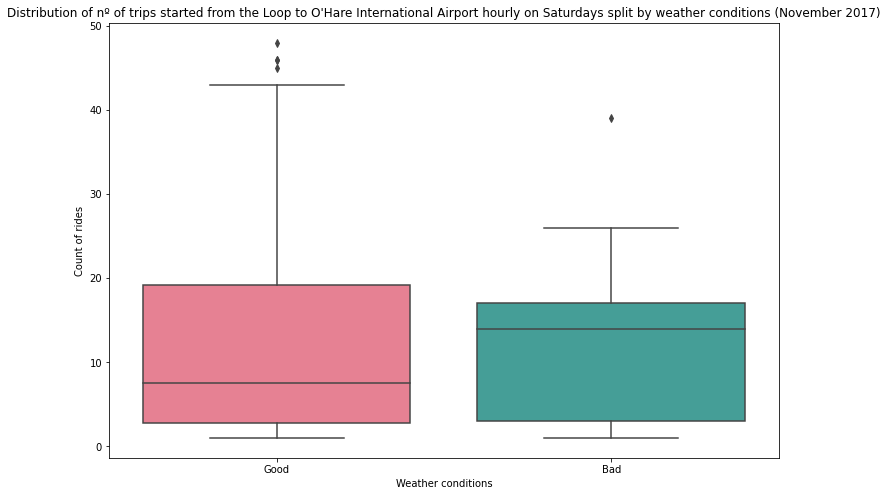

The average count of trips started hourly was prooved to be stable regardless of weather conditons. However, the median count of rides was almost twice as high when the weather was good, since a spike in the count of rides in some hours with good weather is skewing the mean right. This is more likely due to more people getting to the Airport at a rush-hour, or at night, and not necessarily related to the favorable weather condition itself. The conclusion we can get to, is that weather conditions are not hitting the amount of rides started, but they are impacting on their duration.

Finally, we plotted a violinplot (similar to a boxplot, but including a density estimation) of trips duration in seconds for each weather condition.

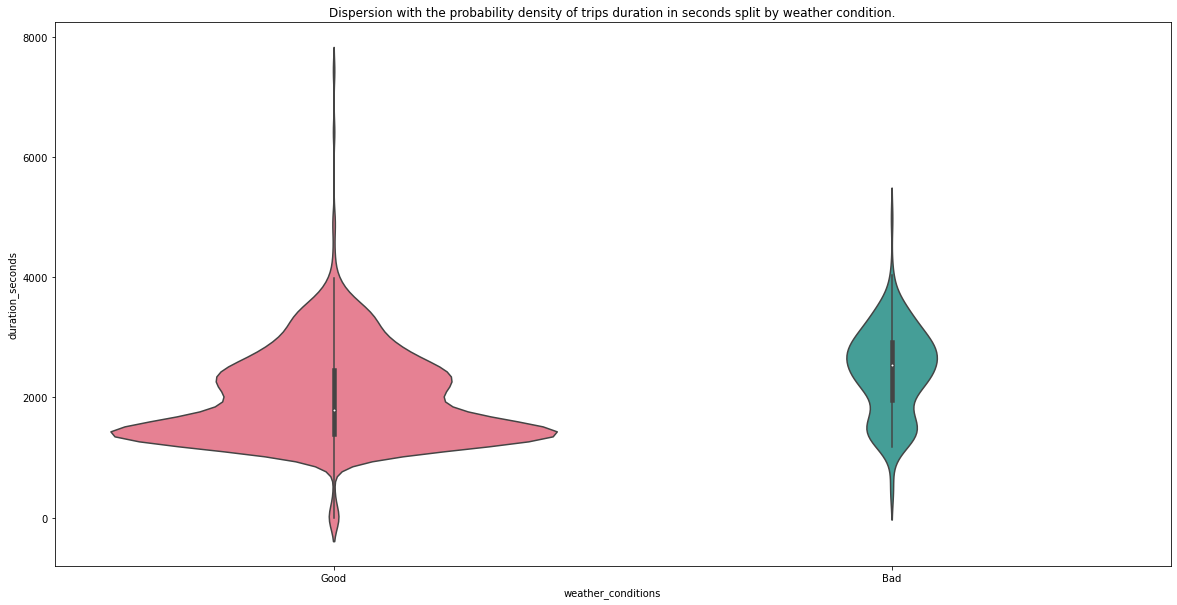

The violin drafting the dispersion of rides duration in hours with good weather is wider when the duration is shorter, and the other one is wider at the top, and narrower at the bottom. This means that in most hours the weather was good and the trips duration remained shorter than 2000 seconds. However, when the weather was bad, most trips lasted between 2000 and 3000 seconds.


Since we were working with a sample including only data from Saturdays of November 2017, we'll use hypothesis testing to assess whether the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

6) Hypothesis testing: "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

Null hypothesis: "The average duration of rides from the Loop to O'Hare International Airport is the same on rainy Saturdays"

Alternative hypothesis: "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays"

Statistical test: Hypothesis on the Equality of Two Population Mean.

alpha= 0.05

equal_var= True (p_value_levene > alpha)

result: We reject the null hypothesis. The average ride duration differs on rainy Saturdays

**Conclusion:** Based on this hypothesis testing, we can ensure that the average trip duration is different on rainy Saturdays. This makes sense from the perspective that the traffic is usually more caothic when the weather conditions are averse. Knowing this beforehand will come in very handy when forecasting the amount of cars working on rainy days. Since riders will take longer to end their trip and free up the vehicle to start a new ride, the company will need more of them on the road to meet passsengers demand.